In [1]:
import numpy as np
import pandas as pd
import os
import glob

import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt

## Merge datasets

Concatenate all the dataframes from different subjects into one dataframe.

In [2]:
if not os.path.exists('data.csv'):
    df = pd.DataFrame()
    for path in glob.glob("./datasets/*"):
        cat_csv = glob.glob(f"{path}/*.csv")
        for csv in cat_csv:
            df = pd.concat([df, pd.read_csv(csv)], axis=0)
    df.to_csv(f"./data.csv", index=False)

else:
    df = pd.read_csv("./data.csv")

## Data cleaning

Generally the data returned by arxiv api is pretty clean, we only need to perform some basic cleaning on merged dataset:

- Drop columns if no title and summary
- Drop duplicates if title and summary are the same
- Sort by date again

Further cleaning will be done in the specific tasks.

In [3]:
df = df.dropna(subset=['title', 'authors'])
df = df.sort_values(by='updated', ascending=False)
df = df.drop_duplicates(subset=['title', 'authors'])
len(df)

146021

## Data visualization

### Categories distribution

In [4]:
def filter(data, pct: float):
    """make entries with less than pct of total sum as others"""
    n = data.sum()
    data['others'] = data[data < n * pct].sum()
    data = data[data >= n * pct]
    return data.sort_values(ascending=False).to_dict()

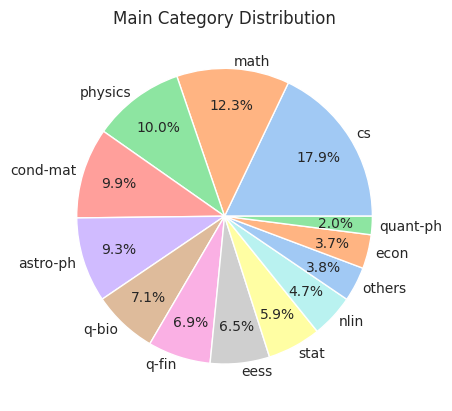

In [5]:
all_counts = df['main_category'].value_counts()
all_counts = filter(all_counts, 0.02)

sns.set_style("dark")
sns.set_palette('pastel')
plt.pie(all_counts.values(), labels=all_counts.keys(),
        autopct='%1.1f%%', labeldistance=1.05, pctdistance=0.75,)
plt.title('Main Category Distribution')
plt.show()

Our whole dataset is balanced, next look at the distribution of each subject in the dataset.

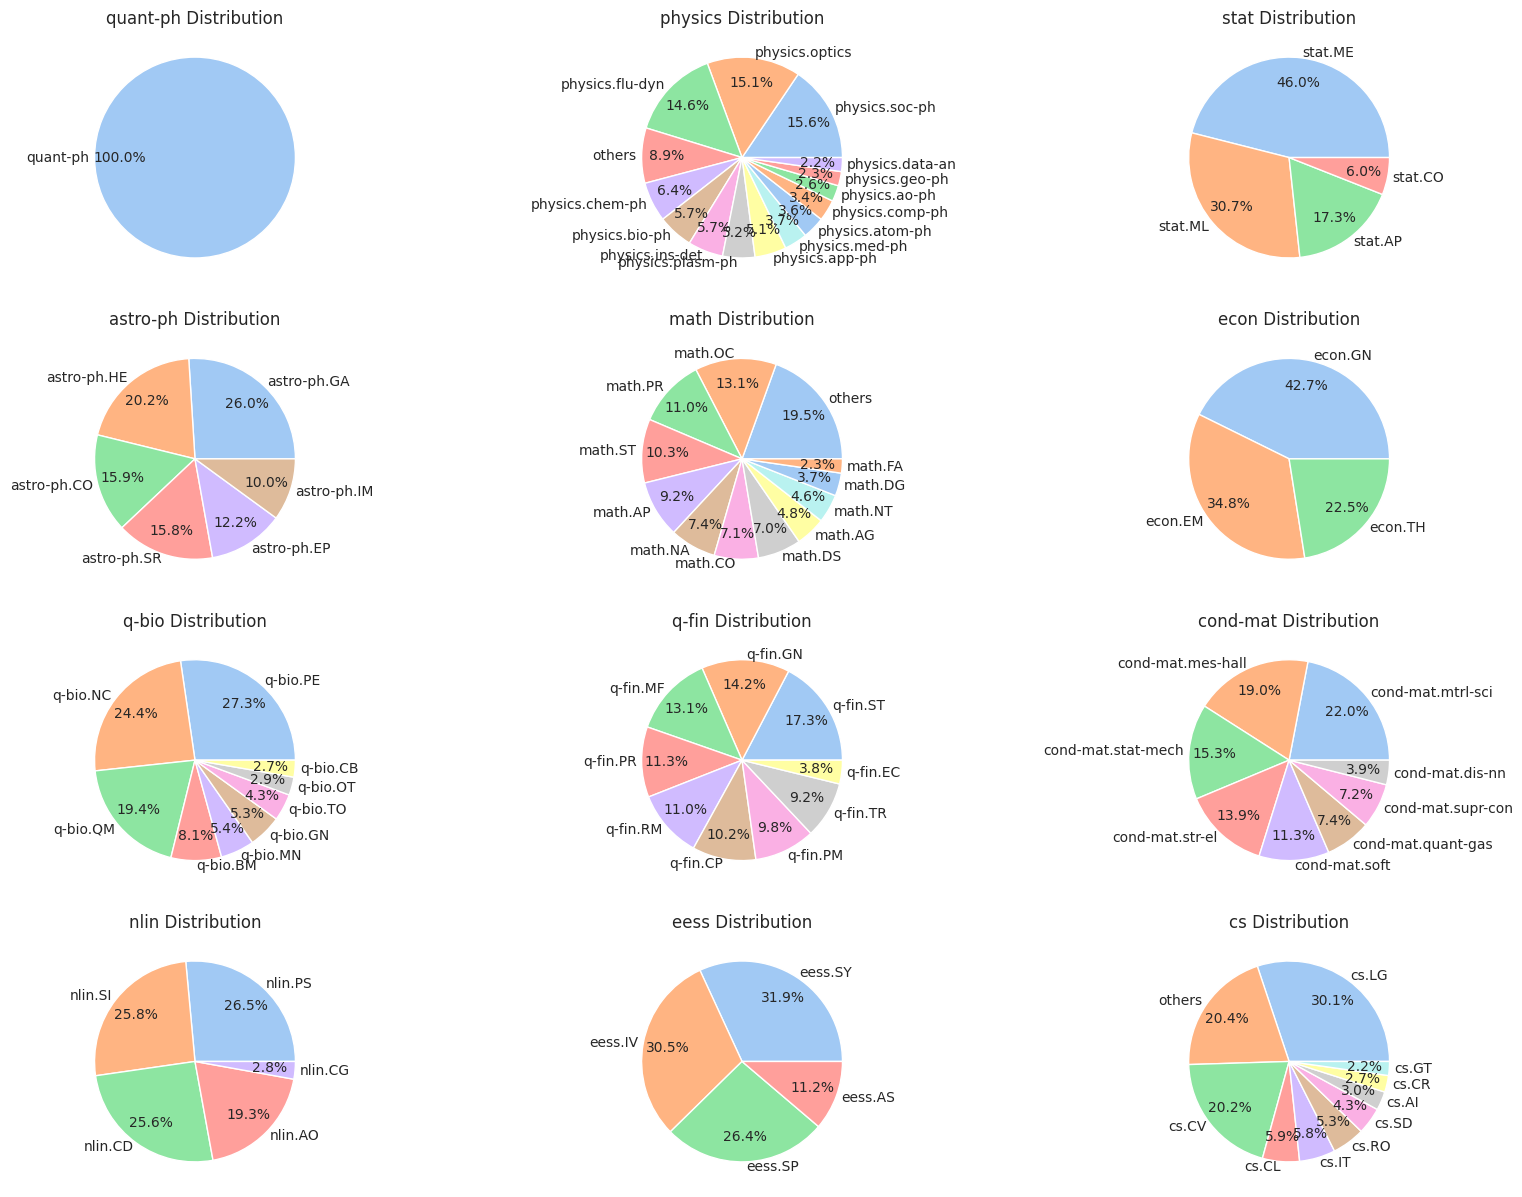

In [6]:
all_cats = all_counts.keys()
all_cats = set(all_cats) - set(['others'])


fig, axs = plt.subplots(4, 3, figsize=(20, 15))
for i, cat in enumerate(all_cats):
    row = i // 3
    col = i % 3
    cat_df = df.query(f"main_category == '{cat}'")
    cat_count = filter(cat_df['term'].value_counts(), 0.02)
    axs[row, col].pie(cat_count.values(), labels=cat_count.keys(),
                      autopct='%1.1f%%', labeldistance=1.05, pctdistance=0.75,)
    axs[row, col].set_title(f"{cat} Distribution")
plt.show()

### Publication percentage

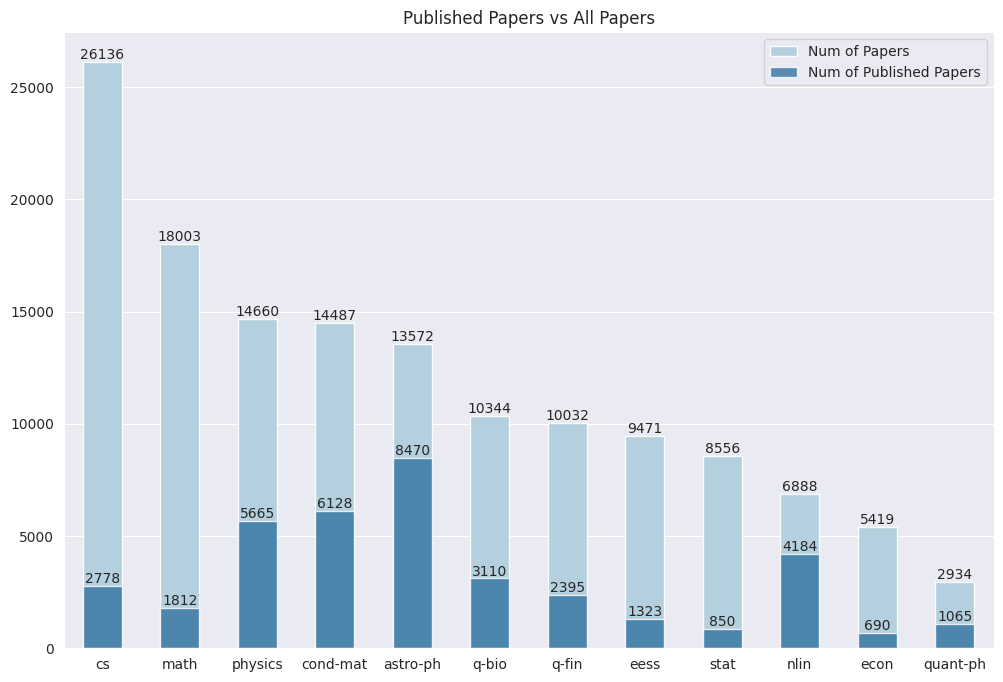

In [7]:
published = {}

if all_counts.get('others'):
    all_counts.pop('others')

for cat in all_counts:
    cat_df = df.query(f"main_category == '{cat}'")
    cat_published = cat_df['doi'].count()
    published[cat] = cat_published
categories = list(published.keys())
paper_num = list(all_counts.values())
published_num = list(published.values())
pct_published = [p / n for p, n in zip(published_num, paper_num)]

sns.set_style('darkgrid')  # Set the plot style
colors = sns.color_palette("Paired")
plt.figure(figsize=(12, 8))
plt.title('Published Papers vs All Papers')
ax = sns.barplot(x=categories, y=paper_num, alpha=0.9,
                 color=colors[0], errorbar="sd", width=0.5,
                 label='Num of Papers')
sns.barplot(x=categories, y=published_num,
            alpha=0.8, color=colors[1], errorbar="sd", width=0.5,
            label='Num of Published Papers')
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge')

plt.legend()
plt.show()

### Who likes to publish on arxiv?

Paper submitted/updated from March 2023 to April 2023

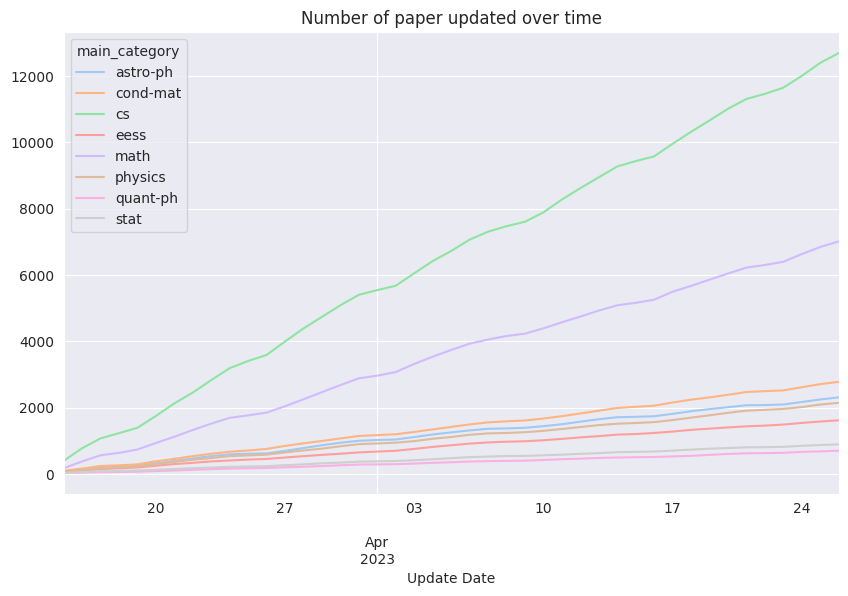

In [100]:
colors = sns.color_palette("Set2")
cut_off = '2023-3-15'
sub_df = df.query("main_category in @categories")
sub_df = df[df['updated'] > cut_off]
grouped = sub_df.groupby([pd.Grouper(key='updated', freq='D'),
                      'main_category']).count()

pivot = grouped['paper_id'].unstack().fillna(0)
pivot = pivot.cumsum()

# drop categories with less than 500 papers
num_papers = pivot.iloc[-1]
cols = num_papers[num_papers > 500].index
pivot = pivot[cols]

ax = pivot.plot(figsize=(10, 6))
ax.set_title('Number of paper updated over time')
ax.set_xlabel('Update Date')
plt.show()

## Goal

- Automatically classify papers into different subjects
- Extract keywords(methods, datasets, etc.) from papers
- Find out is there any feature that can help us to determine whether a paper can be published